In [1]:
import os, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score


2025-12-31 19:27:46.588794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767209266.778308      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767209266.832621      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED = 2019
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# Paths / Config
# =========================
DATA_DIR = "../input/aptos2019-blindness-detection"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test_images")

IMG_SIZE = 300
BATCH_SIZE = 8

EPOCHS_WARMUP = 2
EPOCHS_FINE   = 5

N_SPLITS = 5  # 5-fold CV

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

train_paths = train_df["id_code"].apply(lambda x: os.path.join(TRAIN_IMG_DIR, x + ".png")).values
labels_reg  = train_df["diagnosis"].values.astype(np.float32)  # regression target
labels_strat = train_df["diagnosis"].values.astype(int)        # stratify labels

test_paths = test_df["id_code"].apply(lambda x: os.path.join(TEST_IMG_DIR, x + ".png")).values

train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis=1), mask.any(axis=0))]
    elif img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray > tol
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        return np.stack([img1, img2, img3], axis=-1)
    return img


def minimal_preprocess(path, img_size=IMG_SIZE):
    path = path.decode("utf-8")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # نفس crop_from_gray يلي عندك
    img = crop_image_from_gray(img, tol=7)

    # resize فقط (بدون Ben enhancement)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    img = np.clip(img, 0, 255).astype(np.float32)
    return img


def tf_minimal_preprocess(path):
    img = tf.numpy_function(minimal_preprocess, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img



In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(paths, labels=None, weights=None, training=False):
    if labels is None:
        ds = tf.data.Dataset.from_tensor_slices(paths)
        ds = ds.map(tf_minimal_preprocess, num_parallel_calls=AUTOTUNE)
    else:
        if weights is None:
            weights = np.ones_like(labels, dtype=np.float32)
        else:
            weights = weights.astype(np.float32)

        ds = tf.data.Dataset.from_tensor_slices((paths, labels, weights))

        def _map(p, y, w):
            img = tf_minimal_preprocess(p)
            return img, y, w

        ds = ds.map(_map, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(1024, seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [6]:
def build_model(img_size=IMG_SIZE):
    data_aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.10),
    ], name="data_augmentation")

    inputs = layers.Input(shape=(img_size, img_size, 3), dtype=tf.float32)
    x = data_aug(inputs)
    x = layers.Lambda(preprocess_input, name="effnet_preprocess")(x)

    base = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base.trainable = False

    # مهم: training=False يخلي BatchNorm inference-mode حتى أثناء fine-tuning
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="linear")(x)  # regression 0..4

    model = keras.Model(inputs, outputs)
    return model, base


In [7]:
class QWKHistory(keras.callbacks.Callback):
    def __init__(self, val_ds, y_true):
        super().__init__()
        self.val_ds = val_ds
        self.y_true = y_true.astype(int)
        self.val_qwk = []

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_ds, verbose=0).reshape(-1)
        y_pred = np.clip(np.rint(preds), 0, 4).astype(int)
        qwk = cohen_kappa_score(self.y_true[:len(y_pred)], y_pred, weights="quadratic")

        self.val_qwk.append(qwk)
        if logs is not None:
            logs["val_qwk"] = qwk  # مهم لحتى ModelCheckpoint/EarlyStopping يراقبوا هالقيمة

        print(f"\nEpoch {epoch+1} — val_QWK: {qwk:.4f}")


def plot_kappa(qwk_list, title="Validation QWK (Kappa)"):
    epochs = range(1, len(qwk_list) + 1)
    plt.figure(figsize=(6,4), dpi=120)
    plt.plot(epochs, qwk_list, label="Kappa (QWK)")
    plt.xlabel("Epoch")
    plt.ylabel("QWK")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [8]:
def plot_loss(hist_warm, hist_fine, title="Training vs Validation Loss"):
    train_loss = hist_warm.history.get("loss", []) + hist_fine.history.get("loss", [])
    val_loss   = hist_warm.history.get("val_loss", []) + hist_fine.history.get("val_loss", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(9,4), dpi=120)
    plt.plot(epochs, train_loss, label="Training")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from scipy.optimize import minimize

class OptimizedRounder:
    def __init__(self):
        self.coef_ = None

    @staticmethod
    def _apply_thresholds(preds, coef):
        coef = np.sort(coef)
        return np.digitize(preds, coef)  # 0..4

    def _loss(self, coef, preds, y_true):
        y_pred = self._apply_thresholds(preds, coef)
        return -cohen_kappa_score(y_true, y_pred, weights="quadratic")

    def fit(self, preds, y_true, init_coef=(0.5, 1.5, 2.5, 3.5)):
        preds = preds.reshape(-1)
        y_true = y_true.astype(int)

        res = minimize(
            self._loss,
            x0=np.array(init_coef, dtype=np.float64),
            args=(preds, y_true),
            method="Nelder-Mead"
        )
        self.coef_ = np.sort(res.x)
        return self

    def predict(self, preds, coef=None):
        if coef is None:
            coef = self.coef_
        return self._apply_thresholds(preds.reshape(-1), coef)


In [10]:
NUM_CLASSES = 5

def compute_sample_weights(y_int, num_classes=NUM_CLASSES):
    """
    inverse frequency:
    w_c = N / (K * count_c)
    ثم نرجّع وزن لكل عينة حسب كلاسها.
    """
    y_int = y_int.astype(int)
    counts = np.bincount(y_int, minlength=num_classes)
    N = len(y_int)
    w_per_class = N / (num_classes * np.maximum(counts, 1))
    w = w_per_class[y_int].astype(np.float32)
    return w, w_per_class, counts


counts: [1805.  370.  999.  193.  295.]
class_w: [0.21592525 1.053365   0.3901352  2.0194044  1.3211697 ]

==================== Fold 1/5 ====================


I0000 00:00:1767209304.624432      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767209304.625022      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2


E0000 00:00:1767209323.884922      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1767209411.975065     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 0.9879
Epoch 1 — val_QWK: 0.8395
367/367 ━━━━━━━━━━━━━━━━━━━━ 381s 760ms/step - loss: 0.9864 - val_loss: 0.4464 - val_qwk: 0.8395
Epoch 2/2
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.5368
Epoch 2 — val_QWK: 0.8758
367/367 ━━━━━━━━━━━━━━━━━━━━ 339s 694ms/step - loss: 0.5367 - val_loss: 0.3934 - val_qwk: 0.8758
Restoring model weights from the end of the best epoch: 2.
Epoch 1/5


E0000 00:00:1767210045.543646      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 0.2058
Epoch 1 — val_QWK: 0.8867

Epoch 1: val_qwk improved from -inf to 0.88669, saving model to best_fold1.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 360s 713ms/step - loss: 0.2058 - val_loss: 0.1878 - val_qwk: 0.8867 - learning_rate: 5.0000e-05
Epoch 2/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.2020
Epoch 2 — val_QWK: 0.8857

Epoch 2: val_qwk did not improve from 0.88669
367/367 ━━━━━━━━━━━━━━━━━━━━ 327s 671ms/step - loss: 0.2019 - val_loss: 0.1707 - val_qwk: 0.8857 - learning_rate: 5.0000e-05
Epoch 3/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.1792
Epoch 3 — val_QWK: 0.8808

Epoch 3: val_qwk did not improve from 0.88669
367/367 ━━━━━━━━━━━━━━━━━━━━ 325s 668ms/step - loss: 0.1792 - val_loss: 0.1531 - val_qwk: 0.8808 - learning_rate: 5.0000e-05
Epoch 4/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1819
Epoch 4 — val_QWK: 0.8785

Epoch 4: val_qwk did not improve from 0.88669

Epoch 4: ReduceLROnPlateau red

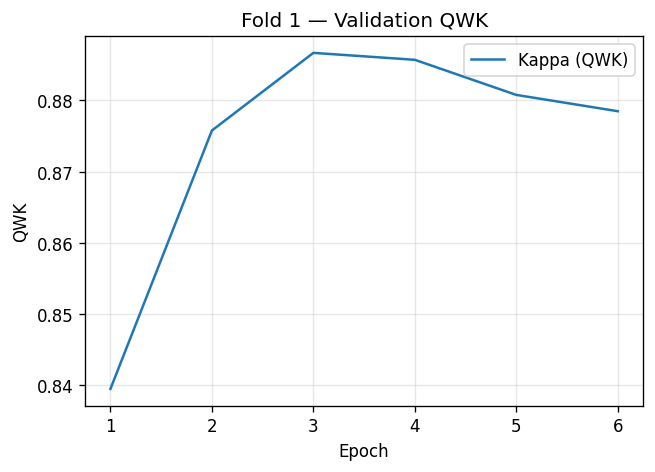

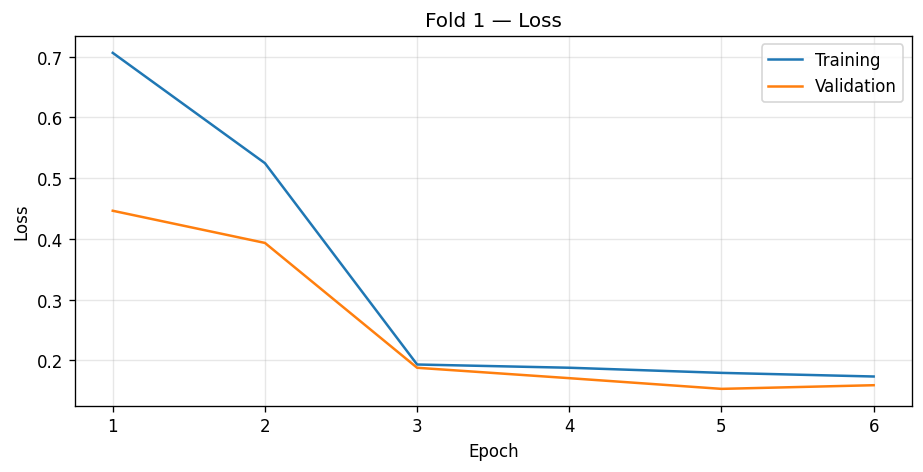


==================== Fold 2/5 ====================
Epoch 1/2


E0000 00:00:1767211495.063389      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.9465
Epoch 1 — val_QWK: 0.8157
367/367 ━━━━━━━━━━━━━━━━━━━━ 362s 719ms/step - loss: 0.9449 - val_loss: 0.5948 - val_qwk: 0.8157
Epoch 2/2
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.5077
Epoch 2 — val_QWK: 0.8254
367/367 ━━━━━━━━━━━━━━━━━━━━ 330s 682ms/step - loss: 0.5076 - val_loss: 0.4925 - val_qwk: 0.8254
Restoring model weights from the end of the best epoch: 2.
Epoch 1/5


E0000 00:00:1767212188.515164      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.2089
Epoch 1 — val_QWK: 0.8281

Epoch 1: val_qwk improved from -inf to 0.82805, saving model to best_fold2.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 355s 711ms/step - loss: 0.2089 - val_loss: 0.2127 - val_qwk: 0.8281 - learning_rate: 5.0000e-05
Epoch 2/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1821
Epoch 2 — val_QWK: 0.8530

Epoch 2: val_qwk improved from 0.82805 to 0.85296, saving model to best_fold2.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 330s 683ms/step - loss: 0.1821 - val_loss: 0.1901 - val_qwk: 0.8530 - learning_rate: 5.0000e-05
Epoch 3/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1903
Epoch 3 — val_QWK: 0.8271

Epoch 3: val_qwk did not improve from 0.85296

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
367/367 ━━━━━━━━━━━━━━━━━━━━ 328s 677ms/step - loss: 0.1902 - val_loss: 0.2478 - val_qwk: 0.8271 - learning_rate: 5.0000e-05
Epoch 4/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step

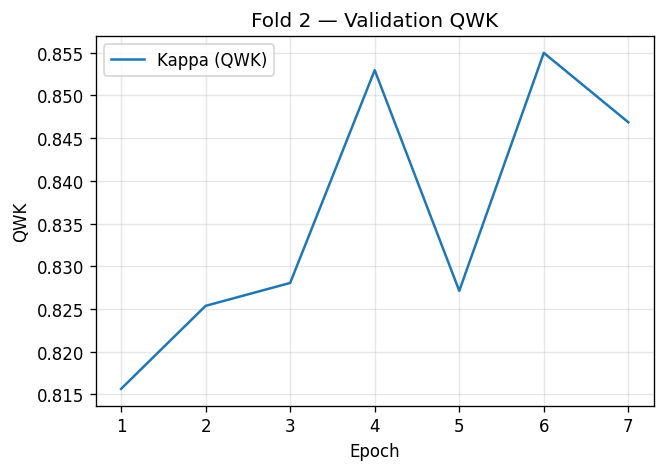

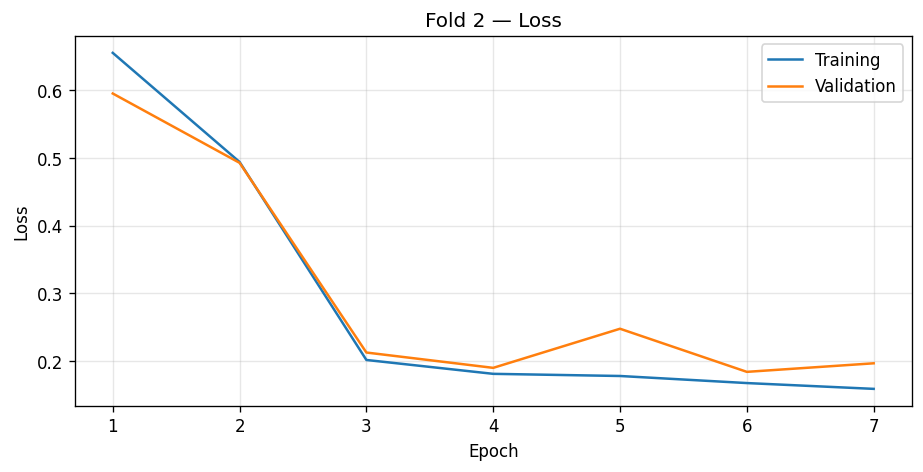


==================== Fold 3/5 ====================
Epoch 1/2


E0000 00:00:1767213965.823133      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.9596
Epoch 1 — val_QWK: 0.8138
367/367 ━━━━━━━━━━━━━━━━━━━━ 354s 710ms/step - loss: 0.9582 - val_loss: 0.5371 - val_qwk: 0.8138
Epoch 2/2
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.5027
Epoch 2 — val_QWK: 0.8102
367/367 ━━━━━━━━━━━━━━━━━━━━ 376s 694ms/step - loss: 0.5026 - val_loss: 0.5947 - val_qwk: 0.8102
Restoring model weights from the end of the best epoch: 1.
Epoch 1/5


E0000 00:00:1767214698.669668      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 0.2174
Epoch 1 — val_QWK: 0.7791

Epoch 1: val_qwk improved from -inf to 0.77911, saving model to best_fold3.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 362s 724ms/step - loss: 0.2173 - val_loss: 0.2564 - val_qwk: 0.7791 - learning_rate: 5.0000e-05
Epoch 2/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.1736
Epoch 2 — val_QWK: 0.8503

Epoch 2: val_qwk improved from 0.77911 to 0.85028, saving model to best_fold3.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 331s 685ms/step - loss: 0.1737 - val_loss: 0.1999 - val_qwk: 0.8503 - learning_rate: 5.0000e-05
Epoch 3/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1822
Epoch 3 — val_QWK: 0.8582

Epoch 3: val_qwk improved from 0.85028 to 0.85823, saving model to best_fold3.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 328s 680ms/step - loss: 0.1822 - val_loss: 0.1934 - val_qwk: 0.8582 - learning_rate: 5.0000e-05
Epoch 4/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.1751
Epoch 4 — val_QWK:

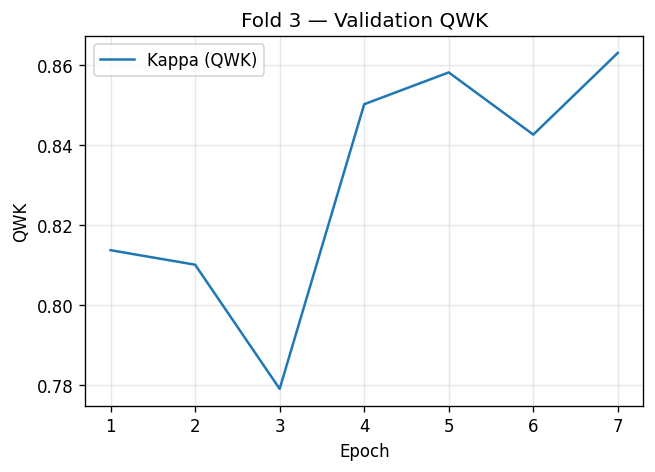

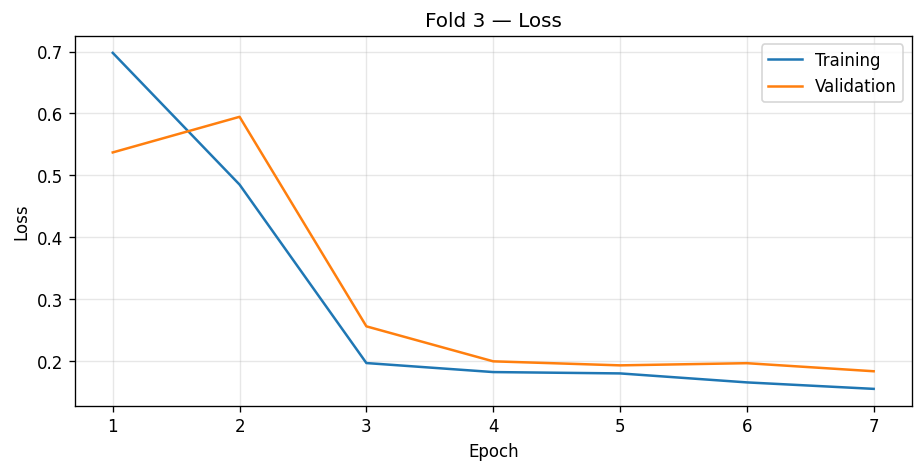


==================== Fold 4/5 ====================
Epoch 1/2


E0000 00:00:1767216488.433698      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.8931
Epoch 1 — val_QWK: 0.7350
367/367 ━━━━━━━━━━━━━━━━━━━━ 358s 720ms/step - loss: 0.8920 - val_loss: 0.9998 - val_qwk: 0.7350
Epoch 2/2
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.5140
Epoch 2 — val_QWK: 0.8191
367/367 ━━━━━━━━━━━━━━━━━━━━ 338s 701ms/step - loss: 0.5140 - val_loss: 0.4675 - val_qwk: 0.8191
Restoring model weights from the end of the best epoch: 2.
Epoch 1/5


E0000 00:00:1767217185.881616      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.1894
Epoch 1 — val_QWK: 0.8352

Epoch 1: val_qwk improved from -inf to 0.83520, saving model to best_fold4.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 370s 746ms/step - loss: 0.1894 - val_loss: 0.1881 - val_qwk: 0.8352 - learning_rate: 5.0000e-05
Epoch 2/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 0.2010
Epoch 2 — val_QWK: 0.7891

Epoch 2: val_qwk did not improve from 0.83520

Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
367/367 ━━━━━━━━━━━━━━━━━━━━ 343s 717ms/step - loss: 0.2009 - val_loss: 0.2444 - val_qwk: 0.7891 - learning_rate: 5.0000e-05
Epoch 3/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 0.1781
Epoch 3 — val_QWK: 0.8447

Epoch 3: val_qwk improved from 0.83520 to 0.84468, saving model to best_fold4.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 337s 703ms/step - loss: 0.1781 - val_loss: 0.1834 - val_qwk: 0.8447 - learning_rate: 2.5000e-05
Epoch 4/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step

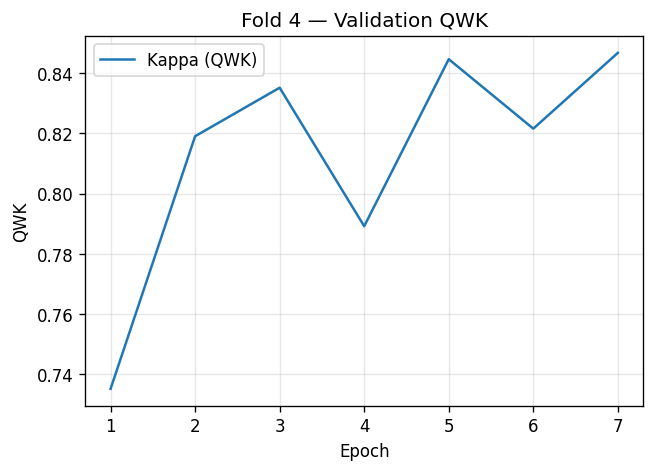

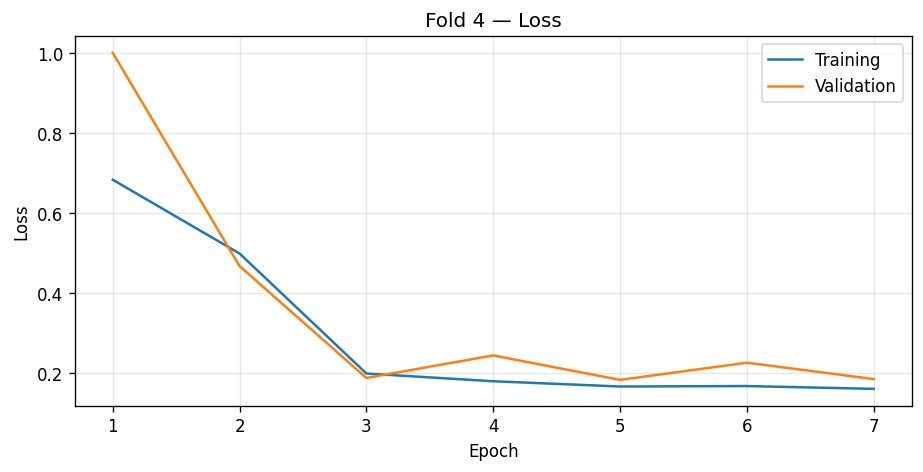


==================== Fold 5/5 ====================
Epoch 1/2


E0000 00:00:1767219017.937233      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 1.1394
Epoch 1 — val_QWK: 0.7940
367/367 ━━━━━━━━━━━━━━━━━━━━ 361s 728ms/step - loss: 1.1371 - val_loss: 0.5670 - val_qwk: 0.7940
Epoch 2/2
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.5215
Epoch 2 — val_QWK: 0.8141
367/367 ━━━━━━━━━━━━━━━━━━━━ 336s 699ms/step - loss: 0.5214 - val_loss: 0.5166 - val_qwk: 0.8141
Restoring model weights from the end of the best epoch: 2.
Epoch 1/5


E0000 00:00:1767219715.874203      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.1977
Epoch 1 — val_QWK: 0.7918

Epoch 1: val_qwk improved from -inf to 0.79177, saving model to best_fold5.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 362s 730ms/step - loss: 0.1977 - val_loss: 0.2897 - val_qwk: 0.7918 - learning_rate: 5.0000e-05
Epoch 2/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 0.1846
Epoch 2 — val_QWK: 0.8494

Epoch 2: val_qwk improved from 0.79177 to 0.84940, saving model to best_fold5.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 338s 704ms/step - loss: 0.1846 - val_loss: 0.1880 - val_qwk: 0.8494 - learning_rate: 5.0000e-05
Epoch 3/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.1756
Epoch 3 — val_QWK: 0.8392

Epoch 3: val_qwk did not improve from 0.84940

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
367/367 ━━━━━━━━━━━━━━━━━━━━ 336s 700ms/step - loss: 0.1757 - val_loss: 0.2061 - val_qwk: 0.8392 - learning_rate: 5.0000e-05
Epoch 4/5
366/367 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

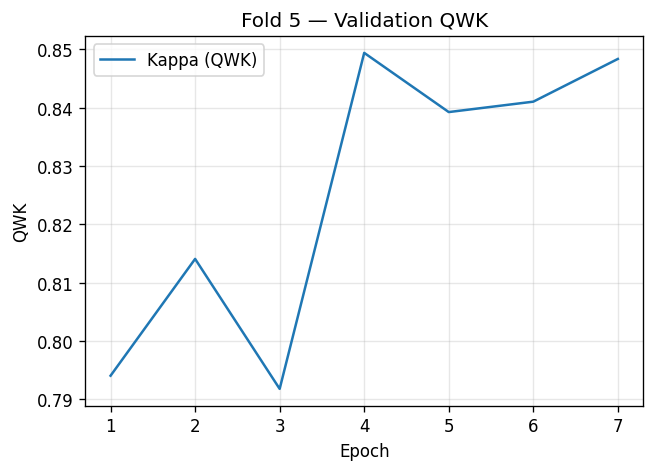

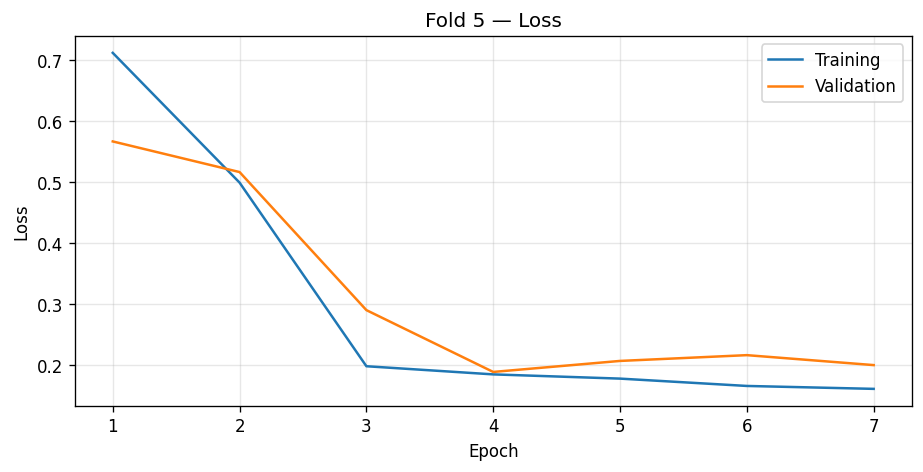

In [ ]:
#### class weights: inverse frequency (balanced-style)
counts = np.bincount(labels_strat, minlength=5).astype(np.float32)
class_w = len(labels_strat) / (5.0 * counts)   # n_samples / (n_classes * count_c)
class_w = class_w / class_w.mean()             # تطبيع اختياري لتخفيف التطرف

print("counts:", counts)
print("class_w:", class_w)

test_ds_full = make_ds(test_paths, labels=None, training=False)

oof_preds = np.zeros(len(train_paths), dtype=np.float32)
test_preds_folds = []

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_paths, labels_strat), start=1):
    print(f"\n==================== Fold {fold}/{N_SPLITS} ====================")

    # clear session لتخفيف مشاكل الذاكرة بين folds
    tf.keras.backend.clear_session()

    X_tr, X_va = train_paths[tr_idx], train_paths[va_idx]
    y_tr, y_va = labels_reg[tr_idx], labels_reg[va_idx]
    
    w_tr = class_w[labels_strat[tr_idx]]
    w_va = np.ones_like(y_va, dtype=np.float32)

    train_ds = make_ds(X_tr, y_tr, weights=w_tr, training=True)
    val_ds   = make_ds(X_va, y_va, weights=w_va, training=False)

    model, base = build_model(IMG_SIZE)

    qwk_hist = QWKHistory(val_ds, y_va)

    warm_ckpt = keras.callbacks.ModelCheckpoint(
        filepath=f"warm_fold{fold}.weights.h5",
        monitor="val_qwk",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=0
    )
    fine_ckpt = keras.callbacks.ModelCheckpoint(
        filepath=f"best_fold{fold}.weights.h5",
        monitor="val_qwk",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    early_warm = keras.callbacks.EarlyStopping(
        monitor="val_qwk",
        mode="max",
        patience=2,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    )
    early_fine = keras.callbacks.EarlyStopping(
        monitor="val_qwk",
        mode="max",
        patience=3,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",       
        mode="auto",
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=1
    )

    # -------- Warm-up --------
    model.compile(
        optimizer=Adam(1e-3),
        loss="mse"
    )
    hist_warm = model.fit(
        train_ds,
        epochs=EPOCHS_WARMUP,
        validation_data=val_ds,
        callbacks=[qwk_hist, warm_ckpt, early_warm], 
        verbose=1
    )

    # -------- Fine-tune --------
    model.load_weights(f"warm_fold{fold}.weights.h5")
    base.trainable = True
    for layer in base.layers[:-10]:
        layer.trainable = False

    # BN freeze (مهم جدًا)
    for layer in base.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=5e-5), 
        loss=tf.keras.losses.Huber(delta=1.0)
    )
    hist_fine = model.fit(
        train_ds,
        epochs=EPOCHS_FINE,
        validation_data=val_ds,
        callbacks=[qwk_hist, fine_ckpt, reduce_lr, early_fine],
        verbose=1
    )
    model.load_weights(f"best_fold{fold}.weights.h5")


    # Plot للكابا لحال (مثل ما بدك)
    plot_kappa(qwk_hist.val_qwk, title=f"Fold {fold} — Validation QWK")
    
    plot_loss(hist_warm, hist_fine, title=f"Fold {fold} — Loss")

    # حمّل أفضل وزن (حتى لو early stop اشتغل، هيك مضمون)
    model.load_weights(f"best_fold{fold}.weights.h5")

    # OOF predictions
    va_pred = model.predict(val_ds, verbose=0).reshape(-1)
    oof_preds[va_idx] = va_pred

    # Test predictions
    te_pred = model.predict(test_ds_full, verbose=0).reshape(-1)
    test_preds_folds.append(te_pred)


In [ ]:
# 1) OOF QWK قبل التحسين (rounding عادي)
oof_rounded = np.clip(np.rint(oof_preds), 0, 4).astype(int)
qwk_before = cohen_kappa_score(labels_strat, oof_rounded, weights="quadratic")
print("OOF QWK (naive rounding):", qwk_before)

# 2) Threshold optimization على OOF
opt = OptimizedRounder().fit(oof_preds, labels_strat)
print("Optimized thresholds:", opt.coef_)

oof_opt = opt.predict(oof_preds)
qwk_after = cohen_kappa_score(labels_strat, oof_opt, weights="quadratic")
print("OOF QWK (optimized thresholds):", qwk_after)

# 3) test preds = average folds ثم طبق thresholds
test_pred_mean = np.mean(np.stack(test_preds_folds, axis=0), axis=0)
test_labels = opt.predict(test_pred_mean).astype(int)

submission = pd.DataFrame({
    "id_code": test_df["id_code"],
    "diagnosis": test_labels
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
